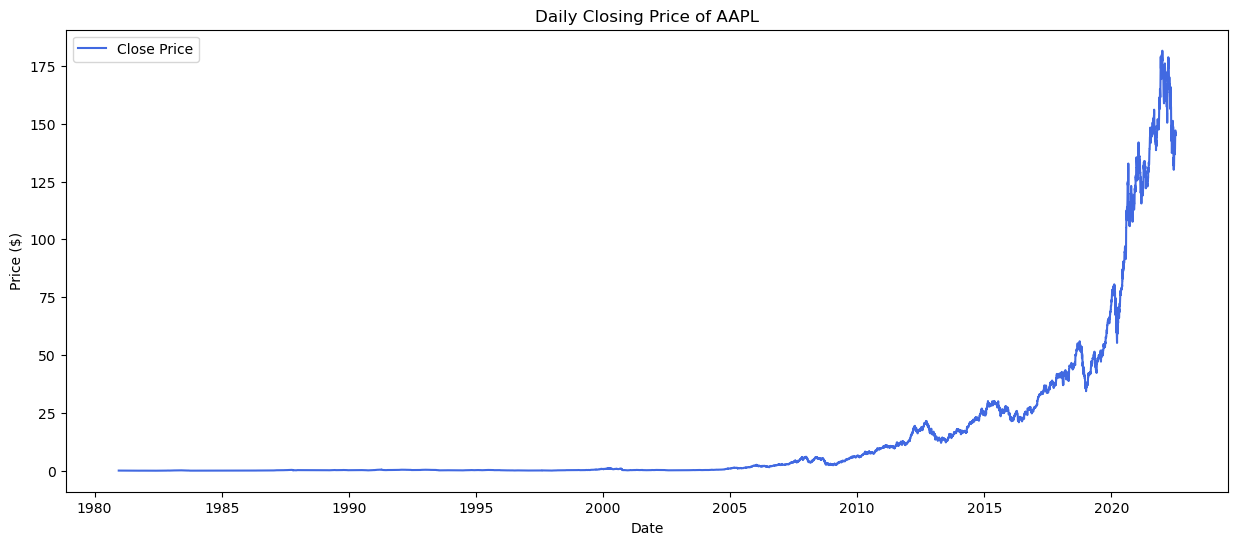

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
%matplotlib inline


display(HTML("<h2>Data Loading and Visualization</h2>"))
display(HTML("<p>This section focuses on loading the historical stock price data and visualizing the closing prices.</p>"))


file_path = './Data/AAPL.csv' 
data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Forward fill to handle missing values
data_daily = data.resample('D').mean().fillna(method='ffill')

# Daily closing prices
plt.figure(figsize=(15, 6))
plt.plot(data_daily['Close'], label='Close Price', color='royalblue')
plt.title('Daily Closing Price of AAPL')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


In [13]:
display(HTML("<h2>Stationarity Check and ARIMA Modeling</h2>"))
display(HTML("<p>We assess the stationarity of the time series and identify optimal parameters for the ARIMA model.</p>"))


In [14]:
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from IPython.display import display, HTML

# Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    display(HTML(f'<strong>ADF Statistic:</strong> {result[0]:.4f}'))
    display(HTML(f'<strong>p-value:</strong> {result[1]:.4f}'))
    critical_values = ', '.join([f'{key}: {value:.3f}' for key, value in result[4].items()])
    display(HTML(f'<strong>Critical Values:</strong> {critical_values}'))

check_stationarity(data_daily['Close'])

# auto_arima to find the best ARIMA model parameters
auto_arima_model = auto_arima(data_daily['Close'], start_p=0, start_q=0, test='adf', 
                              max_p=5, max_q=5, m=1, d=None, seasonal=False, 
                              start_P=0, D=0, trace=True, error_action='ignore', 
                              suppress_warnings=True, stepwise=True)
display(HTML(f'<strong>Auto ARIMA Model Summary:</strong>'))
display(HTML(auto_arima_model.summary().as_html()))


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26270.408, Time=0.67 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26199.785, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26195.695, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26272.645, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26192.912, Time=1.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=26186.872, Time=3.80 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=26187.484, Time=0.65 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=26185.790, Time=1.28 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=26183.816, Time=0.81 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=26185.682, Time=1.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=26187.777, Time=1.90 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=26186.785, Time=0.39 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 13.054 seconds


In [15]:
display(HTML("<h2>SARIMAX Model Fitting and Summary</h2>"))
display(HTML("<p>Building and summarizing the SARIMAX model based on identified parameters.</p>"))


In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from IPython.display import display, HTML

model = SARIMAX(data_daily['Close'], order=auto_arima_model.order, seasonal_order=auto_arima_model.seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

display(HTML(f'<strong>SARIMAX Model Summary:</strong>'))
display(HTML(results.summary().as_html()))


In [17]:
display(HTML("<h2>Model Diagnostics and Predictions</h2>"))
display(HTML("<p>Evaluating the model's diagnostics and forecasting future values.</p>"))


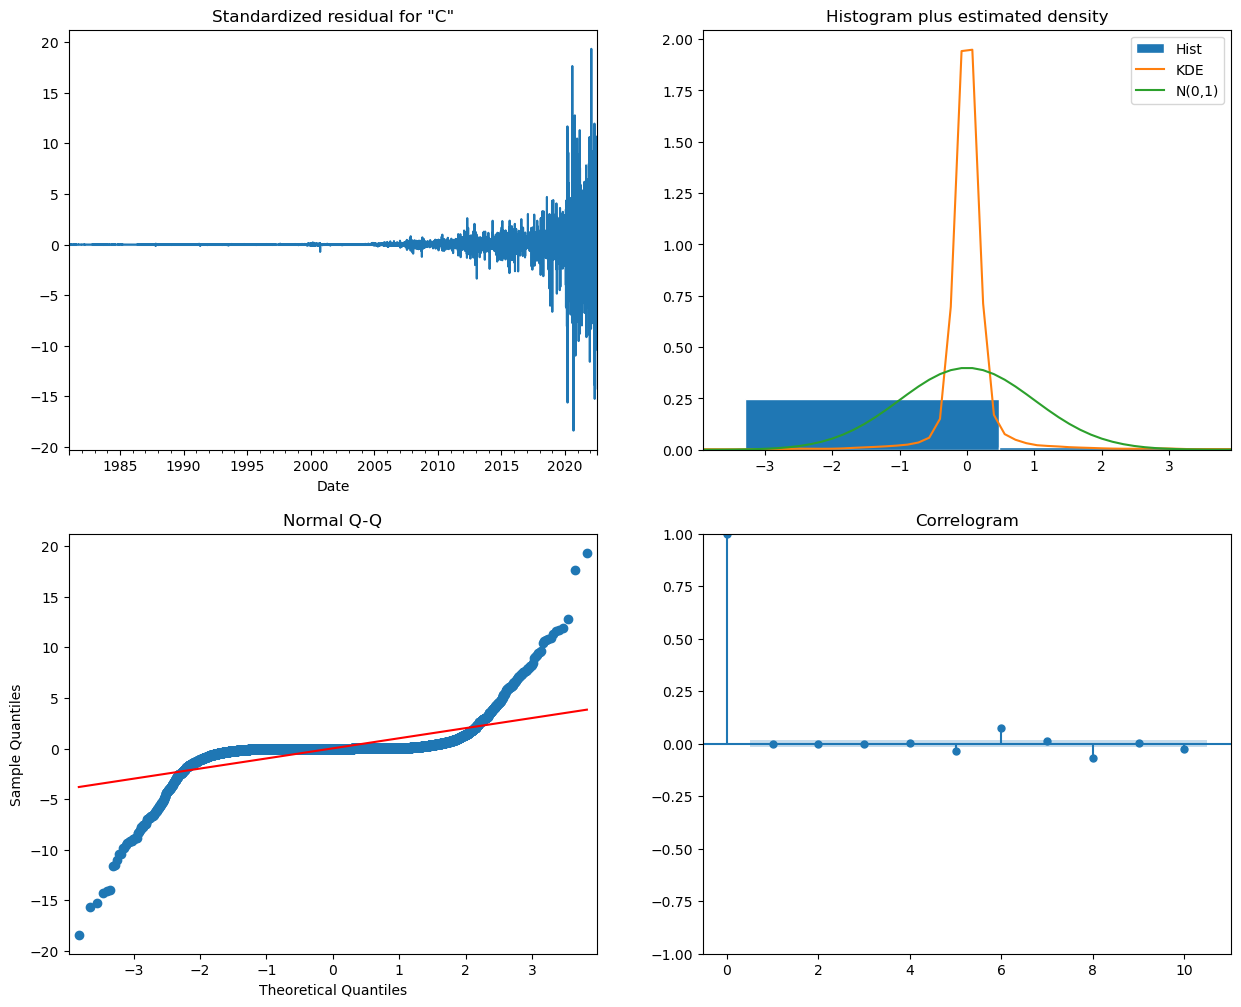

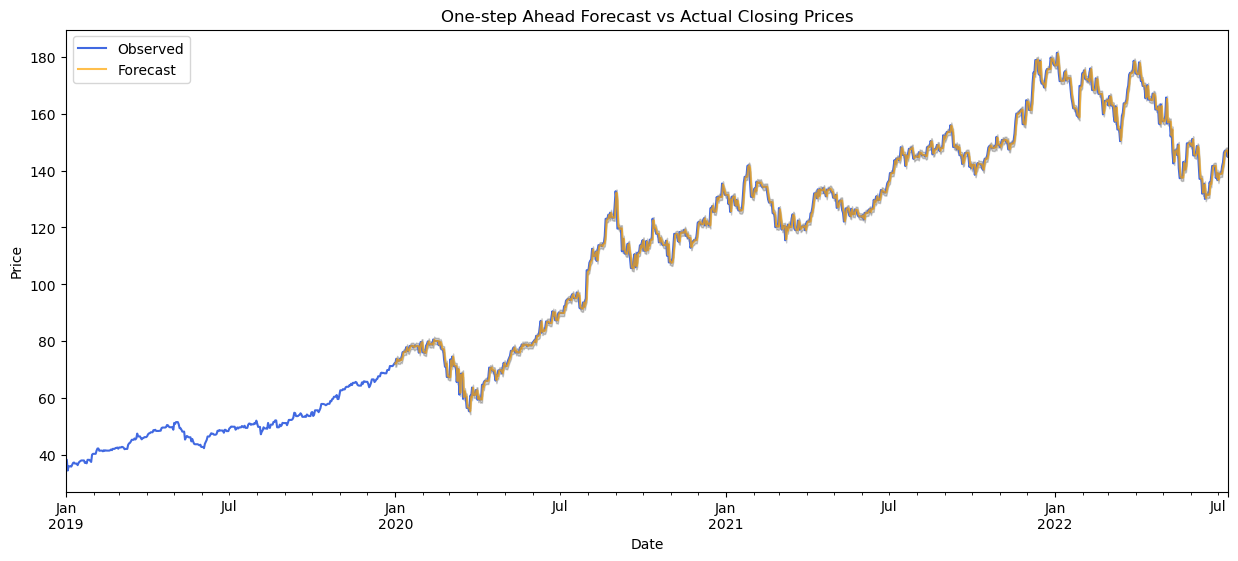

In [18]:
# Run the model diagnostics to check for any unusual behavior
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Generating predictions
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()

plt.figure(figsize=(15, 6))
ax = data_daily['Close']['2019':].plot(label='Observed', color='royalblue')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.7, color='orange')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.title('One-step Ahead Forecast vs Actual Closing Prices')
plt.legend()
plt.show()


In [19]:
display(HTML("<h2>Forecast Accuracy Evaluation</h2>"))
display(HTML("<p>Evaluating the forecast accuracy of the model using MSE, RMSE, and MAPE.</p>"))


In [24]:

from sklearn.metrics import mean_squared_error  

# Mean Absolute Percentage Error function
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Predicted and actual values
y_forecasted = pred.predicted_mean
y_truth = data_daily['Close']['2020-01-01':]

mse = mean_squared_error(y_truth, y_forecasted)
display(HTML(f'<strong>Mean Squared Error (MSE):</strong> {mse:.4f}'))
rmse = np.sqrt(mse)  # Change sqrt to np.sqrt
display(HTML(f'<strong>Root Mean Squared Error (RMSE):</strong> {rmse:.4f}'))

# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
display(HTML(f'<strong>Mean Absolute Percentage Error (MAPE):</strong> {mape:.2f}%'))
